# Normalizing Flows

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Overview</span>

One of the key goals in modern generative models is to find ways of optimizing the probability distribution of a given set of data. To train a model, we typically tune its parameters to maximise the probability of the training dataset under the model. However, most of the real-world distributions that we are interested into are too complex and do not have a closed-form analytical solution. Hence, Gaussians are widely used, but often prove to be too simple to model complex datasets.

The idea of ___<span style="color:violet">Normalizing Flows</span>___ [[1](#reference1),[2](#reference)] has been formalized to address this problem and be able to rely on richer probability distributions. The main idea is to start from a simple probability distribution and approximate a complex multimodal density by *transforming* the simpler density through a sequence of invertible nonlinear transforms. By repeatedly applying the rule for change of variables, the initial density ‘flows’ through the sequence of invertible mappings. At the end of this sequence we obtain a valid probability distribution and hence this type of flow is referred to as a normalizing flow. This allows to rely on distributions of arbitrary complexity and also learn the parameters of these transforms depending only on some mild conditions.

Two examples of transformations of a Unit Gaussian and Uniform distribution using Normalizing Flows are shown below:

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-examples.png" width=1000></img>
</div>

Normalizing flows typically utilize neural networks to implement the transformation functions that map a simple distribution to a more complex one, allowing them to learn complex data distributions; essentially, the "flow" in a normalizing flow is often modeled by a neural network, making it a key component of the method.

## <span style="color:Orange">Normalizing Flows as a Generative Model</span>

In the previous lectures, we have seen Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs) and Diffusion-based models as examples of generative models. However, none of them explicitly learn the probability density function $p(x)$ of the real input data. While VAEs model a lower bound, diffusion-based models only implicitly learn the probability density. GANs on the other hand provide us a sampling mechanism for generating new data, without offering a likelihood estimate. 

The generative model we will look at here, called <span style="color:violet">Normalizing Flows</span>, actually models the true data distribution $p(x)$ and provides us with an exact likelihood estimate. Below, we can visually compare VAEs, GANs and Flows
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-comparison_GAN_VAE_NF.png" width=1000></img>
</div>

The major difference compared to VAEs is that flows use <span style="color:violet">invertible</span> functions $f$ to map the input data $x$ to a latent representation $z$. To realize this, $z$ must be of the same shape as $x$. This is in contrast to VAEs where $z$ is usually much lower dimensional than the original input data. However, an invertible mapping also means that for every data point $x$, we have a corresponding latent representation $z$ which allows us to perform lossless reconstruction ($z$ to $x$). In the visualization above, this means that $x=x'$ for flows, no matter what invertible function $f$ and input $x$ we choose. 

Nonetheless, how are normalizing flows modeling a probability density with an invertible function? The answer to this question is the rule for change of variables. Specifically, given a prior density $p_z(z)$ (e.g. Gaussian) and an invertible function $f$, we can determine $p_x(x)$ as follows:

$$ \Large
\begin{split}
    \int p_x(x) dx & = \int p_z(z) dz = 1 \hspace{1cm}\text{(by definition of a probability distribution)}\\
    \Leftrightarrow p_x(x) & = p_z(z) \left|\frac{dz}{dx}\right| = p_z(f(x)) \left|\frac{df(x)}{dx}\right|
\end{split}
$$

Hence, in order to determine the probability of $x$, we only need to determine its probability in latent space, and get the derivative of $f$.

Note that this is for a univariate distribution, and $f$ is required to be invertible and smooth. For a multivariate case, the derivative becomes a Jacobian of which we need to take the determinant. As we usually use the log-likelihood as objective, we write the multivariate term with logarithms below:

$$ \Large
\log p_x(\mathbf{x}) = \log p_z(f(\mathbf{x})) + \log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|
$$

Although we now know how a normalizing flow obtains its likelihood, it might not be clear what a normalizing flow does intuitively. For this, we should look from the inverse perspective of the flow starting with the prior probability density $p_z(z)$. If we apply an invertible function on it, we effectively "transform" its probability density. 

For instance, if $f^{-1}(z)=z+1$, we shift the density by one while still remaining a valid probability distribution, and being invertible. We can also apply more complex transformations, like scaling: $f^{-1}(z)=2z+1$, but there you might see a difference. When you scale, you also change the volume of the probability density, as for example on uniform distributions (figure credit - [Eric Jang](https://blog.evjang.com/2018/01/nf1.html)):

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-uniform_flow.png" width=600></img>
</div>

You can see that the height of $p(y)$ should be lower than $p(x)$ after scaling. This change in volume represents $\left|\frac{df(x)}{dx}\right|$ in our equation above, and ensures that even after scaling, we still have a valid probability distribution. 

We can go on with making our function $f$ more complex. However, the more complex $f$ becomes, the harder it will be to find the inverse $f^{-1}$ of it, and to calculate the log-determinant of the Jacobian $\log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|$. 

An easier trick to stack multiple invertible functions $f_{1,...,K}$ after each other, as all together, they still represent a single, invertible function. Using multiple, learnable invertible functions, a normalizing flow attempts to transform $p_z(z)$ slowly into a more complex distribution which should finally be $p_x(x)$. We visualize the idea below
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-normalizing_flow_layou.png" width=1000></img>
</div>

Starting from $z_0$, which follows the prior Gaussian distribution, we sequentially apply the invertible functions $f_1,f_2,...,f_K$, until $z_K$ represents $x$. Note that in the figure above, the functions $f$ represent the inverted function from $f$ we had above (here: $f:Z\to X$, above: $f:X\to Z$). This is just a different notation and has no impact on the actual flow design because all $f$ need to be invertible anyways. 

When we estimate the log likelihood of a data point $x$ as in the equations above, we run the flows in the opposite direction than visualized above. Multiple flow layers have been proposed that use a neural network as learnable parameters, such as the planar and radial flow. However, we will focus here on flows that are commonly used in image modeling, and will discuss them in the rest of the notebook along with the details of how to train a normalizing flow.

## <span style="color:Orange">Key Elements and Implementation</span>

### <span style="color:LightGreen">Invertible transformation</span>

<span style="color:violet">Invertible transformation</span>: The core idea of normalizing flows is to use a series of invertible transformations to map a simple distribution (like a Gaussian) to a more complex target distribution, and these transformations are often implemented using neural networks.

### <span style="color:LightGreen">Jacobian Matrix and Determinant</span>

<span style="color:violet">Jacobian Matrix</span>: of a vector-valued function in several variables, the Jacobian generalizes the gradient of a scalar-valued function in several variables, which in turn generalizes the derivative of a scalar-valued function of a single variable. In other words, the Jacobian matrix of a scalar-valued function in several variables is (the transpose of) its gradient and the gradient of a scalar-valued function of a single variable is its derivative.

At each point where a function is differentiable, its Jacobian matrix can also be thought of as describing the amount of "stretching", "rotating" or "transforming" that the function imposes locally near that point.

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-Jacobian.png" width=800></img>
</div>

<span style="color:violet">Jacobian determinant</span>: The determinant of the Jacobian matrix.

The Jacobian determinant is used when making a change of variables when evaluating a multiple integral of a function over a region within its domain. To accommodate for the change of coordinates the magnitude of the Jacobian determinant arises as a multiplicative factor within the integral. This is because the $n$-dimensional $dV$ element is in general a parallelepiped in the new coordinate system, and the $n$-volume of a parallelepiped is the determinant of its edge vectors.

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/NormalizingFlows-JacobianDeterminant.png" width=600></img>
</div>

A nonlinear map $f$ sends a small square (left, in red) to a distorted parallelogram (right, in red). The Jacobian at a point gives the best linear approximation of the distorted parallelogram near that point (right, in translucent white), and the Jacobian determinant gives the ratio of the area of the approximating parallelogram to that of the original square.

When applying a neural network transformation, the Jacobian determinant needs to be calculated to ensure the change of variables formula can be used to compute the probability density of the transformed data.

### <span style="color:LightGreen">Architectures</span>

Popular normalizing flow architectures like <span style="color:violet">planar flows</span> or <span style="color:violet">masked autoregressive flows</span> rely on neural networks to define the transformation functions.

### <span style="color:LightGreen">PyTorch Distributions</span>

<a id="distribs"></a>

In this lecture, we are going to rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`. Most notably, we are going to rely both on the `Distribution` and `Transform` objects.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform

In [3]:
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Inside this toolbox, we can already find some of the major probability distributions that we are used to deal with

In [4]:
p = distrib.Normal(loc=0, scale=1)
p = distrib.Bernoulli(probs=torch.tensor([0.5]))
p = distrib.Beta(concentration1=torch.tensor([0.5]), concentration0=torch.tensor([0.5]))
p = distrib.Gamma(concentration=torch.tensor([1.0]), rate=torch.tensor([1.0]))
p = distrib.Pareto(alpha=torch.tensor([1.0]), scale=torch.tensor([1.0]))

The interesting aspect of these `Distribution` objects is that we can both obtain some samples from it through the `sample` (or `sample_n`) function, but we can also obtain the analytical density at any given point through the `log_prob` function

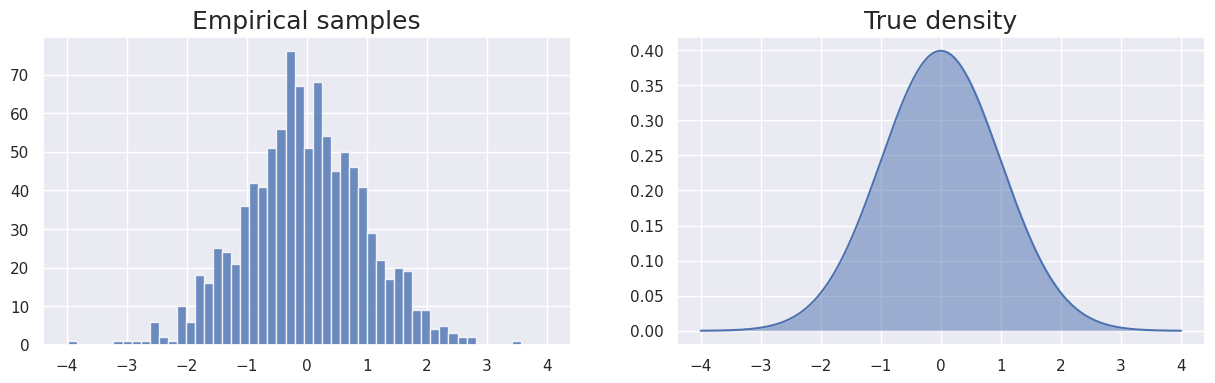

In [5]:
# Based on a normal
n = distrib.Normal(0, 1)
# Obtain some samples
samples = n.sample((1000, ))
# Evaluate true density at given points
density = torch.exp(n.log_prob(torch.Tensor(x))).numpy()
# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);
ax2.plot(x, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);

## <span style="color:Orange">Transforming distributions</span>

### <span style="color:LightGreen">Change of Variables and Flow</span>

In order to transform a probability distribution, we can perform a <span style="color:violet">change of variable</span>. In general, change of variables can be performed in any number of ways. However, here we are interested in probability distributions, which means that we need to *scale* our transformed density so that the total probability still sums to one. This is directly measured with the determinant of our transform (if you need more intuitive examples, you can check the great [Eric Jang's tutorial](https://blog.evjang.com/2018/01/nf1.html)).Hence, we can transform a probability distribution by using an invertible mapping and somehow scaling by the determinant of this mapping. 

Let $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping (meaning that $f^{-1} = g$ and $g\circ f(\mathbf{z})=\mathbf{z}'$). We can use $f$ to transform $\mathbf{z}\sim q(\mathbf{z})$. The resulting random variable $\mathbf{z}'=f(\mathbf{z})$ has the following probability distribution

$$ \Large
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}
$$

where the last equality is obtained through the inverse function theorem [1]. 

Fortunately, this can be easily implemented in PyTorch with the `Transform` classes, that already defines some basic probability distribution transforms. For instance, if we define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, we can apply the transform $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$

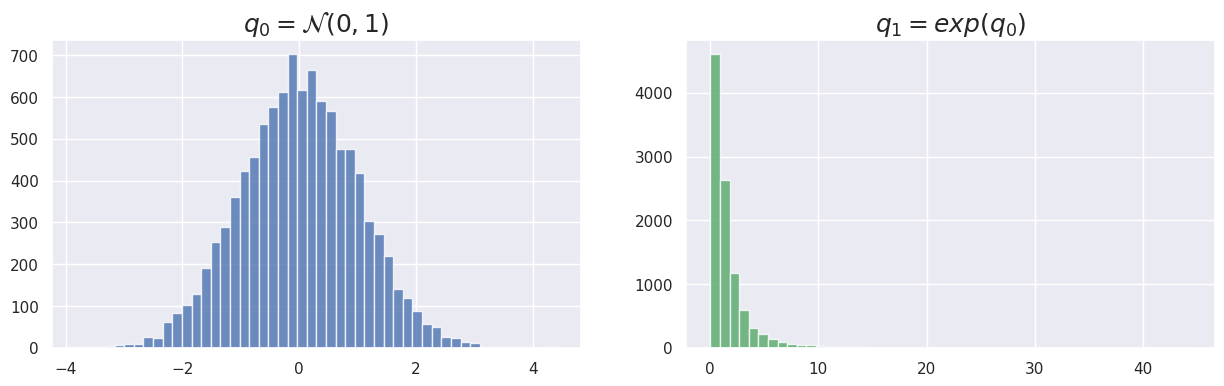

In [6]:
q0 = distrib.Normal(0, 1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, exp_t)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

But remember as the objects `q0` and `q1` are defined as `Distribution`, we can actually observe their true densities instead of just empirical samples

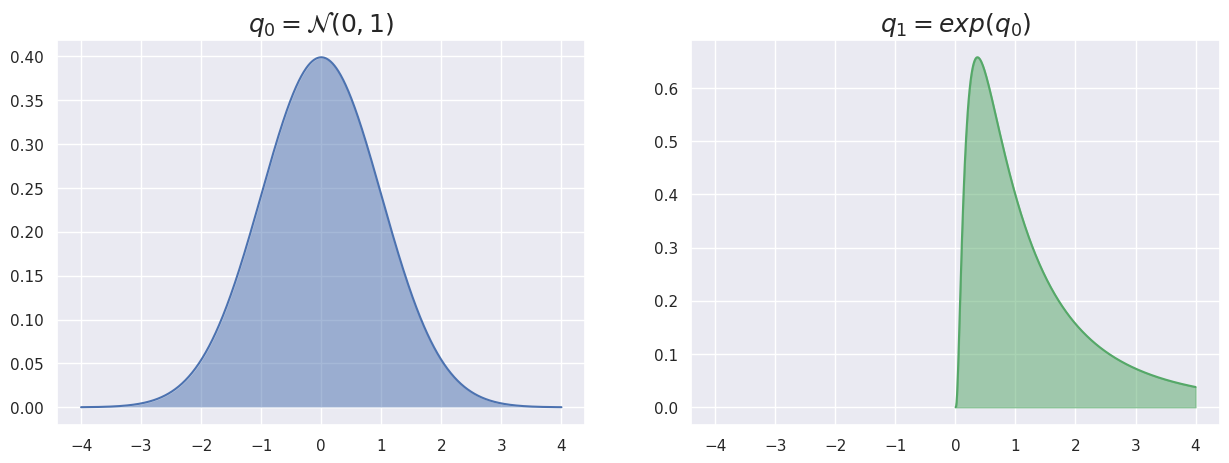

In [7]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
# Filter x to contain only positive values for LogNormal distribution
x_positive = x[x > 0]  
q1_density = torch.exp(q1.log_prob(torch.Tensor(x_positive))).numpy() 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
# Plot q1_density using x_positive
ax2.plot(x_positive, q1_density, color='g'); ax2.fill_between(x_positive, q1_density, 0, alpha=0.5, color='g') 
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

What we obtain here with `q1` is actually the `LogNormal` distribution. Interestingly, several distributions in the `torch.distributions` module are already defined based on `TransformedDistribution`. You can convince yourself of that by lurking in the code of the [`torch.distributions.LogNormal`](https://pytorch.org/docs/stable/_modules/torch/distributions/log_normal.html#LogNormal)

### <span style="color:LightGreen">Chaining Variable Transforms (flows)</span>

<a id="chaining"></a>
Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$ \Large
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ will be given by
   
   $$ \Large
   \begin{align}
   q_k(\mathbf{z}_k) &= q_0(f_1^{-1} \circ f_{2}^{-1} \circ ... \circ f_k^{-1}(\mathbf{z}_k))\prod_{i=1}^k\left|\text{det}\frac{\delta f^{-1}_i}{\delta\mathbf{z}_{i}}\right|\\
   &= q_0(\mathbf{z_0})\prod_{i=1}^k\left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|^{-1}
   \end{align}
   $$
    
where we compute the determinant of the Jacobian of each normalizing flow (as explained in the previous section). This series of transformations can transform a simple probability distribution (e.g. Gaussian) into a complicated multi-modal one. As usual, we will rely on log-probabilities to simplify the computation and obtain 

$$ \Large
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
$$

To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions. Here, this is demonstrated by transforming a `MultivariateNormal` successively with an `ExpTransform` and `AffineTransform`. (Note that the final distribution `q2` is defined as a `TransformedDistribution` directly with a *sequence* of transformations)

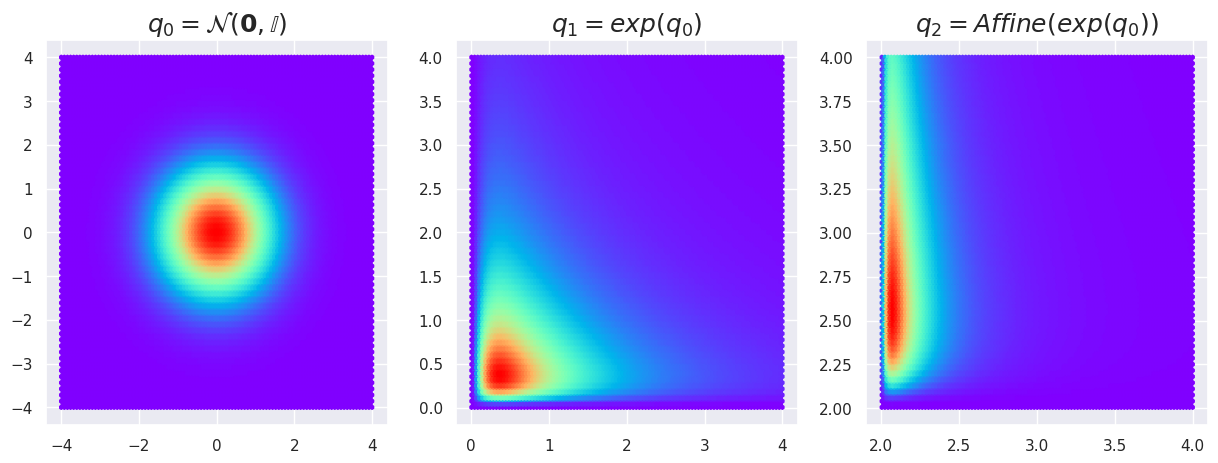

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import numpy as np
import matplotlib.pyplot as plt

q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])

# Filter z to contain only positive values for LogNormal distribution
z_positive = z[z[:,0] > 0] # Filter for positive values in the first column
z_positive = z_positive[z_positive[:,1] > 0] # Filter for positive values in the second column

# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);

# Filter values to be in the support of the transformed distributions
# Apply inverse transforms to check if the original values are valid
z_q1_valid = z[torch.all(f1.inv(torch.tensor(z)) > -np.inf, dim=1)]
# The change is in the next line: we filter z_q2_valid based on the support of q2
# Instead of using > 0, we use > -np.inf to allow for negative values that are still in the support of the distribution
# Apply the inverse of the composed transform to ensure values are within the support of q0
z_q2_valid = z[torch.all(transform.ComposeTransform([f2, f1]).inv(torch.tensor(z)) > -np.inf, dim=1)]  

ax2.hexbin(z_q1_valid[:,0], z_q1_valid[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z_q1_valid))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
# Check if z_q2_valid is empty and handle it
if z_q2_valid.size == 0:
    print("Warning: z_q2_valid is empty. Skipping the plot for q2.")
else:
    # Filter z_q2_valid to be within the support of the transformed distribution
    z_q2_valid_filtered = z_q2_valid[torch.all(torch.isfinite(torch.tensor(z_q2_valid)), dim=1)]
    z_q2_valid_filtered = z_q2_valid_filtered[torch.all(f1.inv(transform.ComposeTransform([f2]).inv(torch.tensor(z_q2_valid_filtered))) > -np.inf, dim=1)]
    # Calculate log_prob only for valid values
    log_prob_q2 = q2.log_prob(torch.Tensor(z_q2_valid_filtered))
    # Filter out NaN values
    valid_indices = torch.isfinite(log_prob_q2)
    z_q2_valid_filtered = z_q2_valid_filtered[valid_indices]
    log_prob_q2 = log_prob_q2[valid_indices]

    ax3.hexbin(z_q2_valid_filtered[:,0], z_q2_valid_filtered[:,1], C=torch.exp(log_prob_q2), cmap='rainbow')
    ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18);

## <span style="color:Orange">Normalizing Flows</span>

<a id="planar"></a>
Now, we are interested in normalizing flows as we could define our own flows. And, most importantly, we could optimize the parameters of these flow in order to fit complex and richer probability distributions. We will see how this plays out by trying to implement the *planar flow* proposed in the original paper by Rezende [1].

### <span style="color:LightGreen">Planar Flow</span>

 A <span style="color:violet">planar normalizing flow</span> is defined as a function of the form

   $$ \Large
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   $$

   where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that:

1. the determinant of their Jacobian can be computed in linear time

2. the transformation is invertible (under usually mild conditions only)
   
As shown in the paper, for the planar flow, the determinant of the Jacobian can be computed in $O(D)$ time by relying on the matrix determinant lemma

$$ \Large
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
$$

$$ \Large
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
$$

Therefore, we have all definitions that we need to implement this flow as a `Transform` object. Note that here the non-linear activation function $h$ is selected as a $tanh$. Therefore the derivative $h'$ is $1-tanh(x)^2$

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import constraints

class PlanarFlow(transform.Transform):

    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias
        # Define domain and codomain
        self.domain = constraints.real  # Input domain is real numbers
        self.codomain = constraints.real # Output domain is real numbers


    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-7)

As before, we can witness the effect of this transform on a given `MultivariateNormal` distribution. You should note here that I am using the density estimation for `q0`, but only display empirical samples from `q1`.

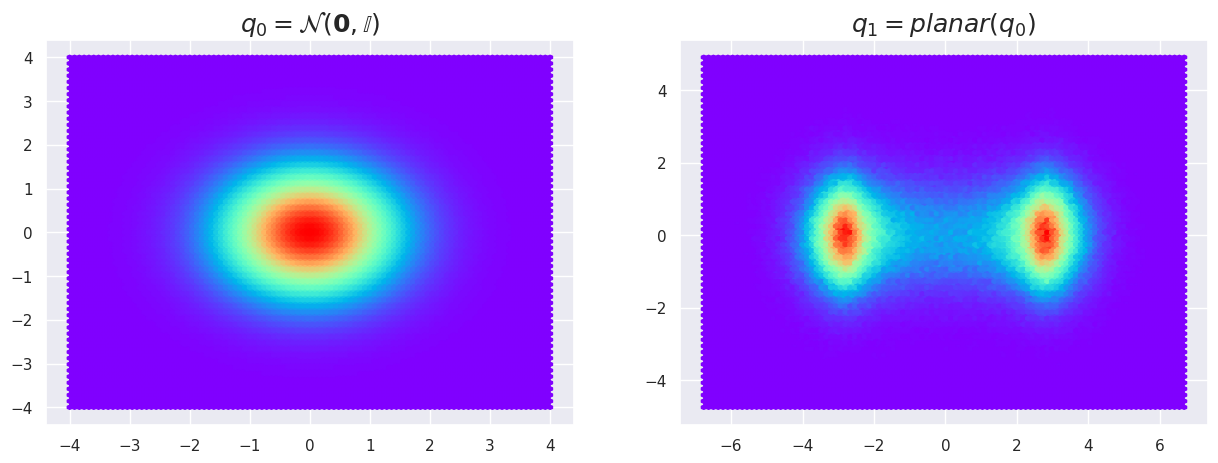

In [10]:
w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0)
q1_samples = q1.sample((int(1e6), ))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

The reason for this is that the `PlanarFlow` is not invertible in all regions of the space. However, if we recall the mathematical reasoning of the previous section, we can see how the change of variables plays out if we are able to compute the determinant of the Jacobian of this transform.

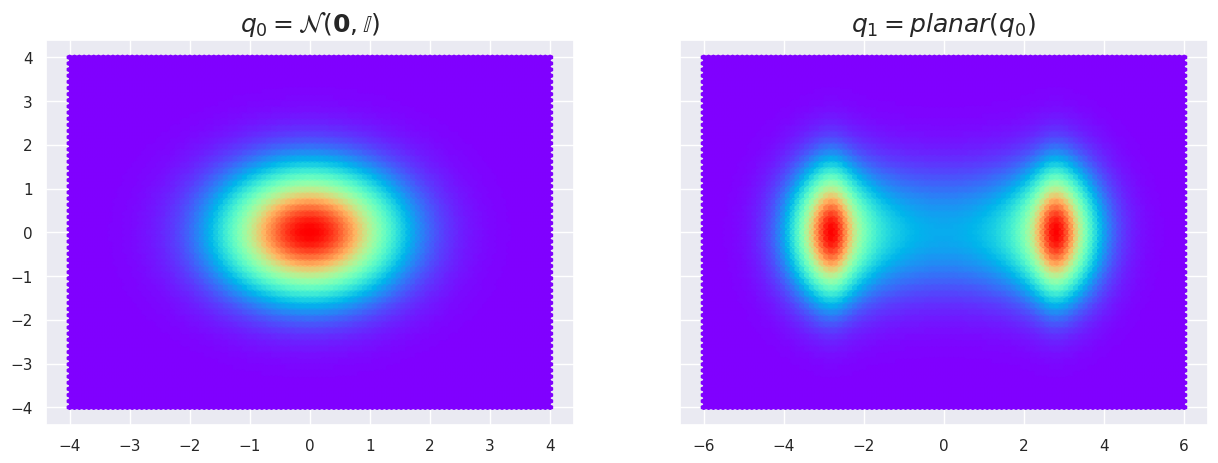

In [11]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Apply our transform on coordinates
f_z = flow_0(torch.Tensor(z))
# Obtain our density
q1_density = q0_density.squeeze() / np.exp(flow_0.log_abs_det_jacobian(torch.Tensor(z)).squeeze())
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

So we were able to "split" our distribution and transform a unimodal gaussian into a multimodal distribution ! Pretty neat 

### <span style="color:LightGreen">Visualizing Parameters Effects</span>

Here, we provide a little toy example so that you can play around with the parameters of the flow in order to get a better understanding of how it operates. As put forward by Rezende [1], this flow is related to the hyperplane defined by $\mathbf{w}^{T}\mathbf{z}+b=0$ and transforms the original density by applying a series of contractions and expansions in the direction perpendicular to this hyperplane.

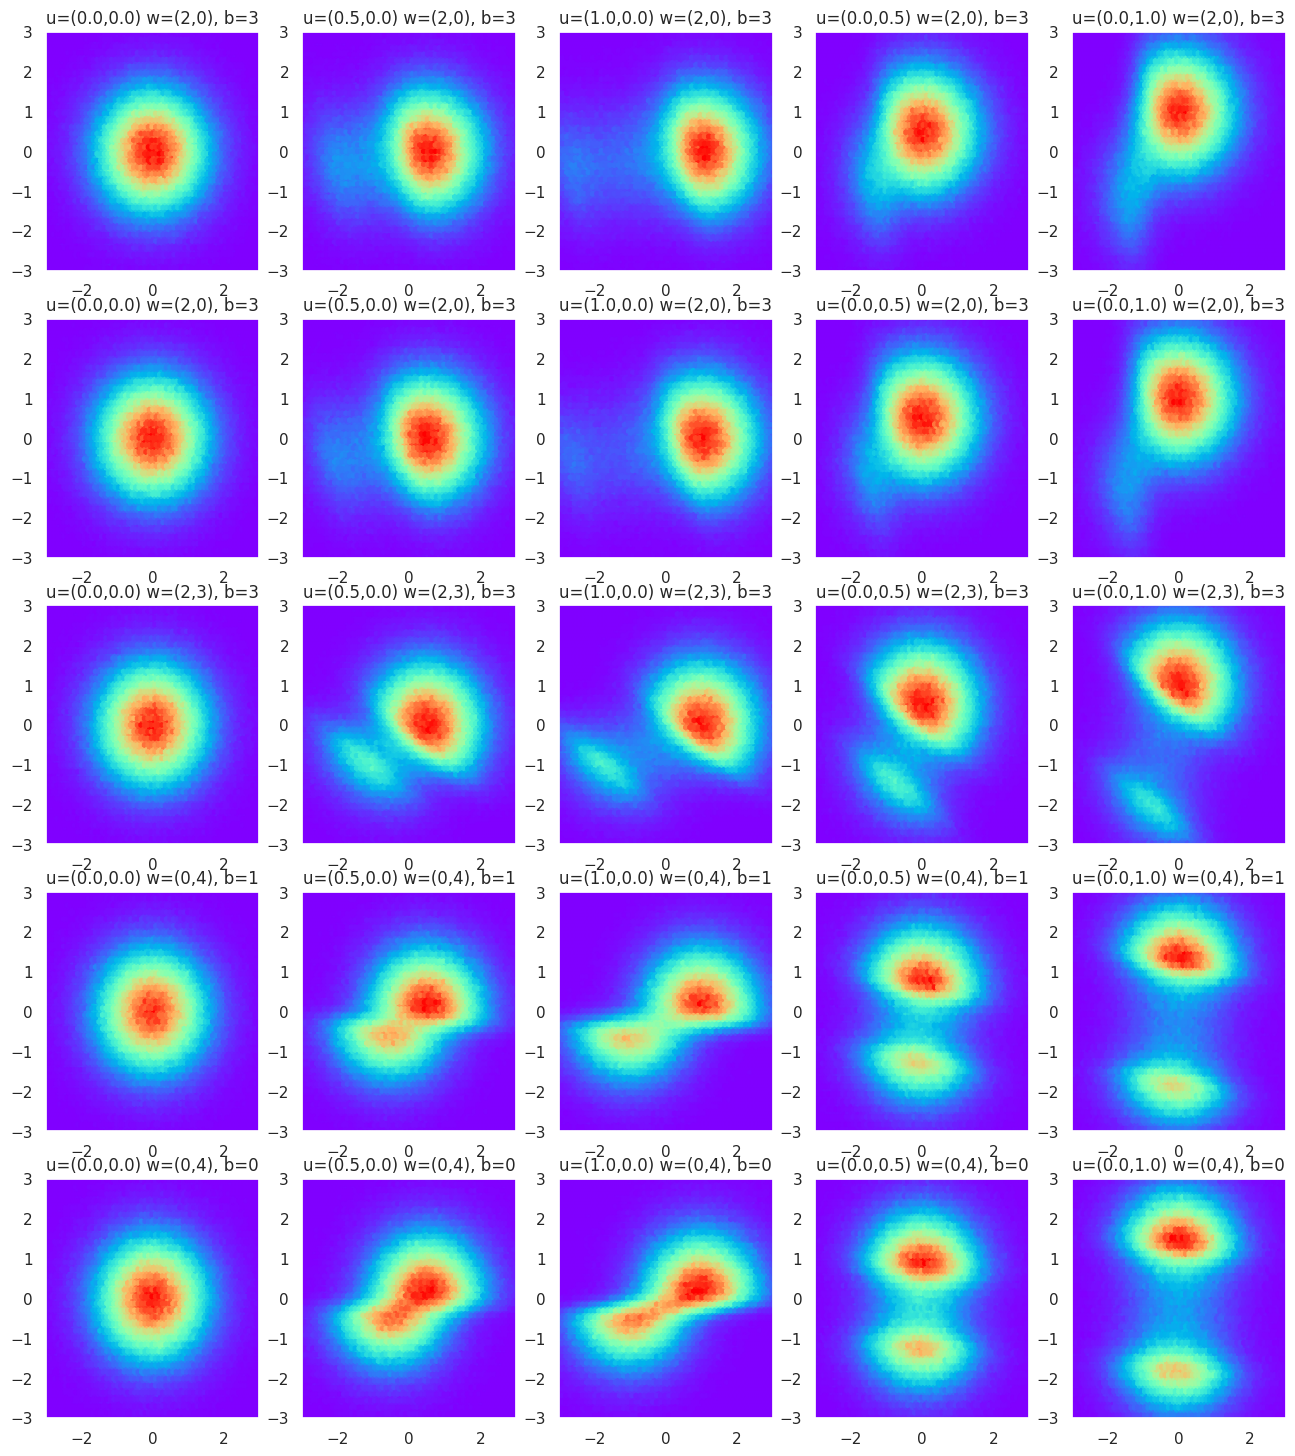

In [12]:
id_figure=1
plt.figure(figsize=(16, 18))
for i in np.arange(5):
    # Draw a random hyperplane
    w = torch.rand(1, 2) * 5
    b = torch.rand(1) * 5
    for j in np.arange(5):
        # Different effects of scaling factor u on the same hyperplane (row)
        u = torch.Tensor([[((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or 0)]])
        flow_0 = PlanarFlow(w, u, b)
        q1 = distrib.TransformedDistribution(q0, flow_0)
        q1_samples = q1.sample((int(1e6), ))
        plt.subplot(5,5,id_figure)
        plt.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
        plt.title("u=(%.1f,%.1f)"%(u[0,0],u[0,1]) + " w=(%d,%d)"%(w[0,0],w[0,1]) + ", " + "b=%d"%b)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        id_figure += 1

## <span style="color:Orange">Optimizing Normalizing Flows</span>

<a id="learning"></a>
Now that we have this magnificent tool, we would like to apply this in order to learn richer distributions and perform *inference*. Now, we have to deal with the fact that the `Transform` object is not inherently parametric and cannot yet be optimized similarly to other modules.

To do so, we will start by defining our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [13]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Thanks to this little trick, we can use the same `PlanarFlow` class as before, that we put back here just to show that the only change is that it now inherits from the `Flow` class (with the small added bonus that now parameters of this flow are also registered in the `Module` interface)

In [14]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()
        # Define domain and codomain
        self.domain = constraints.real  # Input domain is real numbers
        self.codomain = constraints.real # Output domain is real numbers


    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

Now let's say that we have a given complex density that we aim to model through normalizing flows, such as the following one

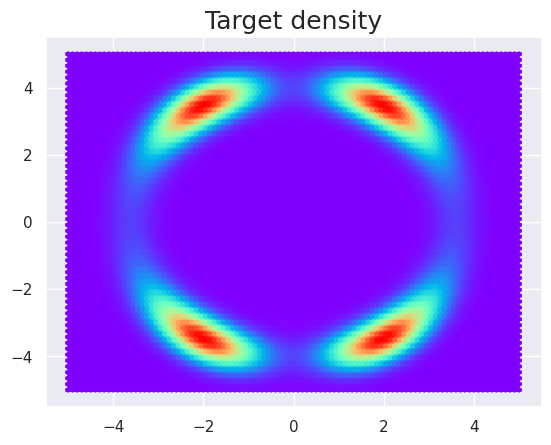

In [15]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Now to approximate such a complicated density, we will need to chain multiple planar flows and optimize their parameters to find a suitable approximation. We can do exactly that like in the following (you can see that we start by a simple normal density and perform 16 successive planar flows)

In [16]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

Now the only missing ingredient is the loss function that is simply defined as follows

In [17]:
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk)+1e-9)).mean()

We can now perform optimization as usual by defining an optimizer, the parameters it will act on and eventually a learning rate scheduler

In [18]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

And now we perform the loop by sampling a batch (here of 512) from the reference Normal distribution, and then evaluating our loss with respect to the density we want to approximate.

Loss (it. 0) : 18.250095
Loss (it. 1000) : 1.947394
Loss (it. 2000) : 1.133390
Loss (it. 3000) : 1.006117
Loss (it. 4000) : 0.932710
Loss (it. 5000) : 0.885981
Loss (it. 6000) : 0.947523
Loss (it. 7000) : 0.850952
Loss (it. 8000) : 0.762654
Loss (it. 9000) : 0.853780
Loss (it. 10000) : 0.814227


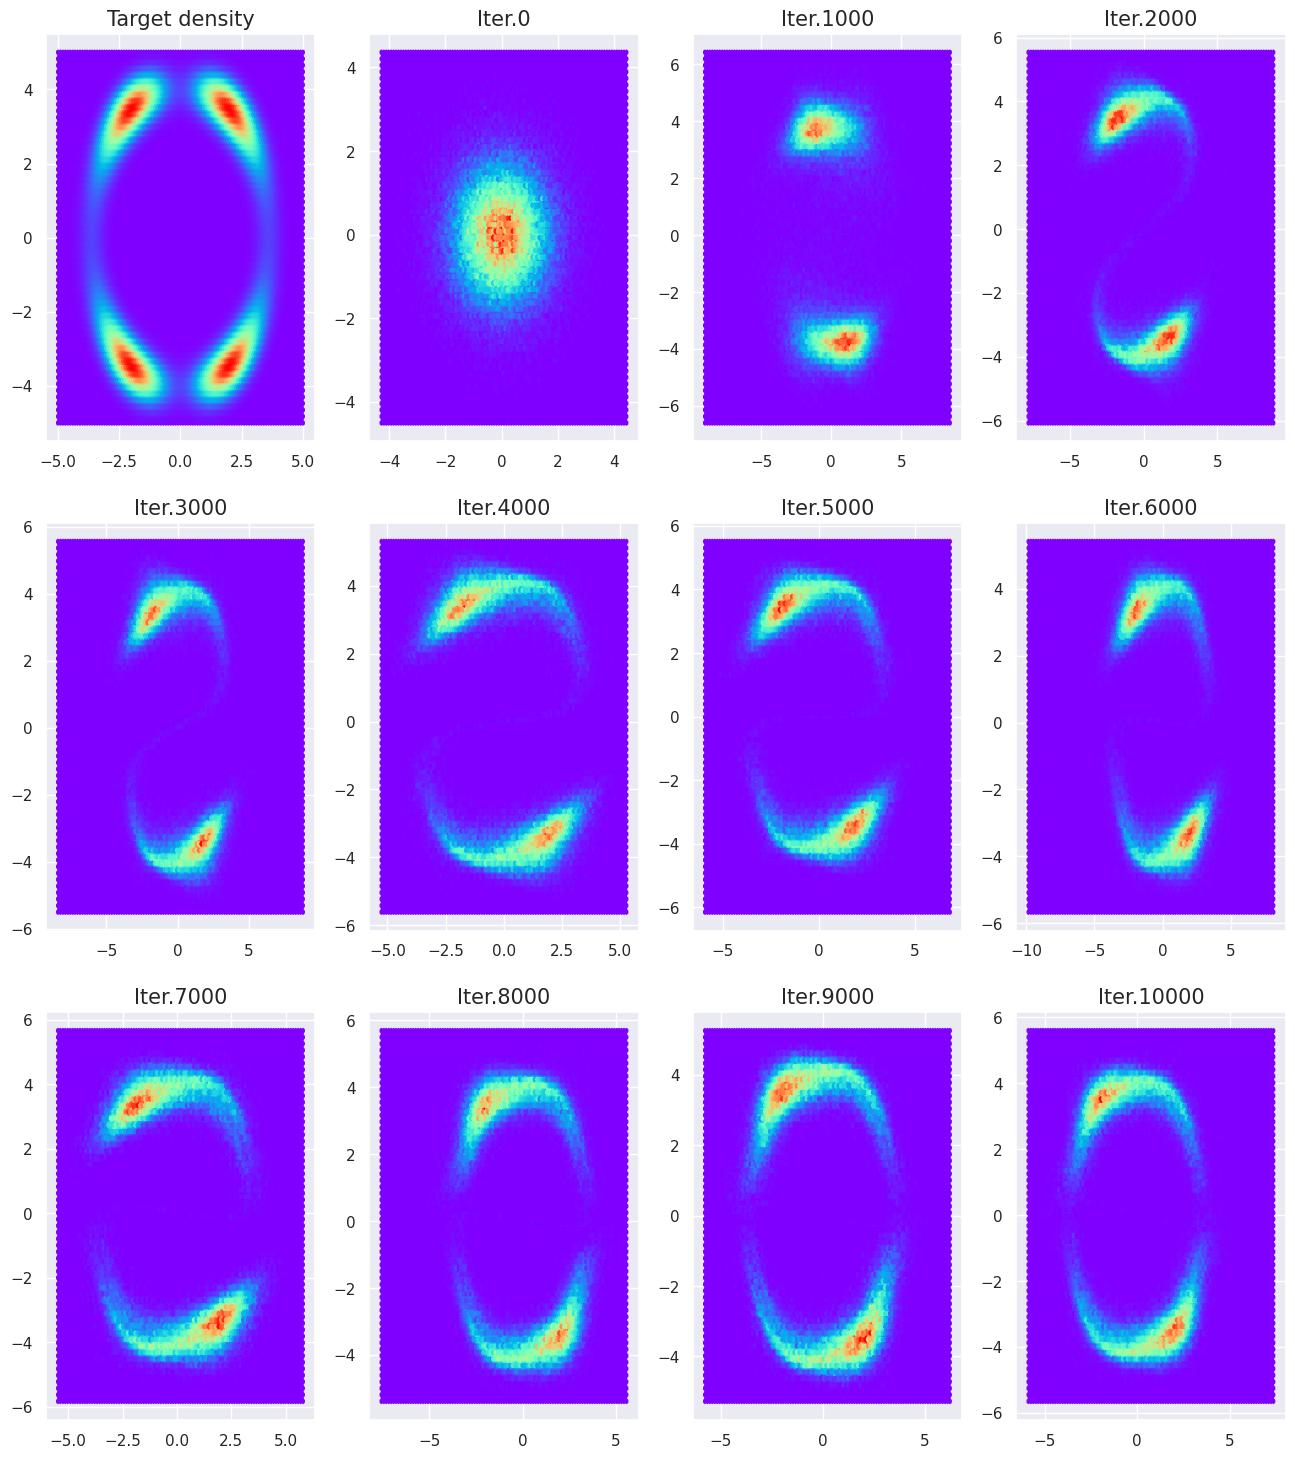

In [19]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

## <span style="color:Orange">References</span>

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015.

### <span style="color:LightGreen">Inspirations and resources</span>

- https://blog.evjang.com/2018/01/nf1.html  
- https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
- https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
- https://github.com/abdulfatir/normalizing-flows
- https://github.com/acids-ircam/pytorch_flows
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * Modified from the following [tutorial](https://github.com/araomv/NormalizingFlow-Tutorial/)

© Copyright 2025